# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [19]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

In [3]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [4]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

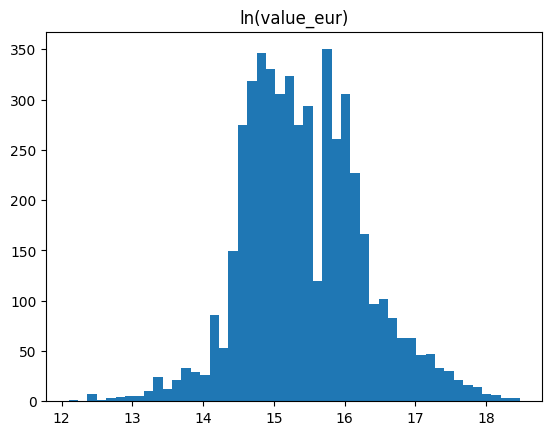

In [5]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [6]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [7]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor()
model.fit(X_train, ylog_train, )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [8]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
#### Ex 1. Ensure your model is not overfitted

> In order to do a deep check on whether the model is overfitting or not, first we will do a search for the best parameters for the model. Once we have the best behaving model, we will retrain it to track it's loss progression along the epochs, both in thraing and validation (test), so we can perfectly see whether it is overfitting or not (we could get a pretty good estimate just by looking at the final results, but the plot looks better if it's a line and we can check if there's any weird behaviour).

> For the metrics, we will use both the MSE loss and the R2 metric.

In [20]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Calculate and print training and test performance metrics."""
    
    y_train_pred = predict_function(model, X_train)
    y_test_pred = predict_function(model, X_test)
    
    metrics = {
        "RMSE_train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "RMSE_test": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "MAE_train": mean_absolute_error(y_train, y_train_pred),
        "MAE_test": mean_absolute_error(y_test, y_test_pred),
        "R2_train": r2_score(y_train, y_train_pred),
        "R2_test": r2_score(y_test, y_test_pred),
    }
    
    print("Model Evaluation:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    return metrics


In [27]:
# Base model
model = XGBRegressor()

param_dist = {
    'max_depth': [2, 3, 4, 5, 6, 8, 10],
    'gamma': [0, 0.05, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1, 5],
    'reg_lambda': [0.1, 1, 5, 10, 20],
    'n_estimators': [3000],
    "learning_rate": [0.05],
    "subsample": [0.8],
}

# Search over the most relevant parameters
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    scoring=make_scorer(r2_score),
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, ylog_train, eval_set=[(X_test, ylog_test)], verbose=False)

# Best parameters and model
best_params = search.best_params_
print("\nBest parameters found:")
for k, v in best_params.items():
    print(f"{k}: {v}")
print("Best cross-validation R²:", round(search.best_score_, 4))

# Train best model again to track loss
model = XGBRegressor(**best_params)

model.fit(
    X_train, ylog_train,
    eval_set=[(X_train, ylog_train), (X_test, ylog_test)],
    eval_metric="rmse",
    verbose=False
)


Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best parameters found:
subsample: 0.8
reg_lambda: 0.1
reg_alpha: 0.1
n_estimators: 3000
max_depth: 3
learning_rate: 0.05
gamma: 0
Best cross-validation R²: 0.9373


c:\Users\pablo\OneDrive\Desktop\IMAT\1º Máster\Explicabilidad\p1-tabular-methods-pablogarciaamolina\.venv\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

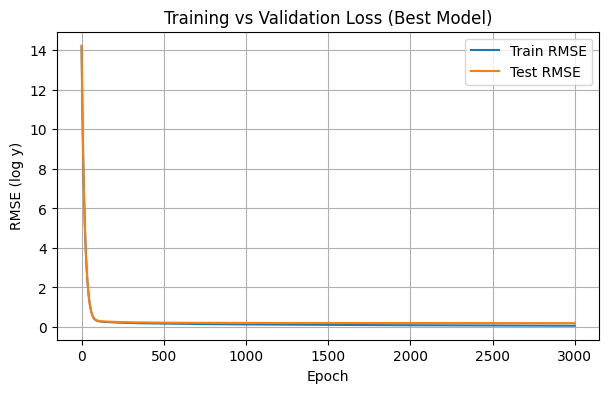

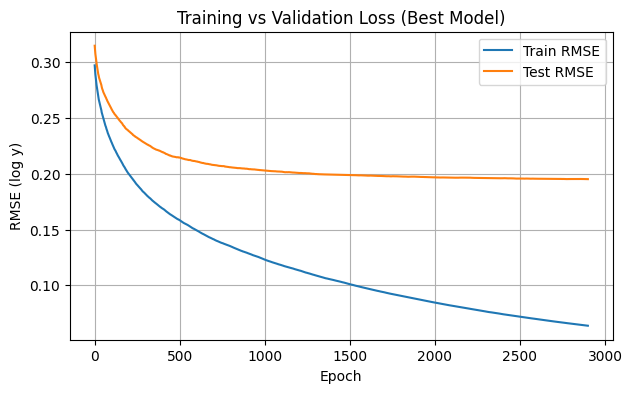

In [28]:
# Extract training history
results = model.evals_result_
train_rmse = results['validation_0']['rmse']
test_rmse = results['validation_1']['rmse']

# Plot RMSE vs epochs
plt.figure(figsize=(7,4))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (log y)')
plt.title('Training vs Validation Loss (Best Model)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(train_rmse[100:], label='Train RMSE')
plt.plot(test_rmse[100:], label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (log y)')
plt.title('Training vs Validation Loss (Best Model)')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Final check on metrics
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)

Model Evaluation:
RMSE_train: 497118.2499
RMSE_test: 2570788.0304
MAE_train: 308442.3173
MAE_test: 1221825.3850
R2_train: 0.9968
R2_test: 0.9173


> We can observe the plots of the evolution of the loss along the epochs (both completly and from epoch 100, since the fast descend at the beginning does not allow to notice the gap in the end). Meeitng the end of the training, the test loss diverges from the train loss as the model starts to overfit. In this case, the overfitting is not critical and can be considered normal, since the difference in loss is no too great and the test loss is still descendian and the end result of R2 metric indicates the model is capable of predict unseen data very accurately. 

---
#### Ex 2. Obtain and plot variable importance measures using the following variable groups

In [35]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

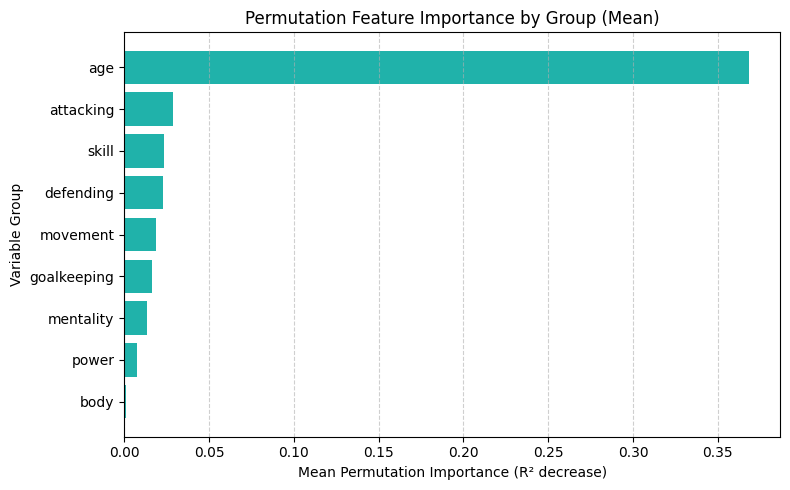

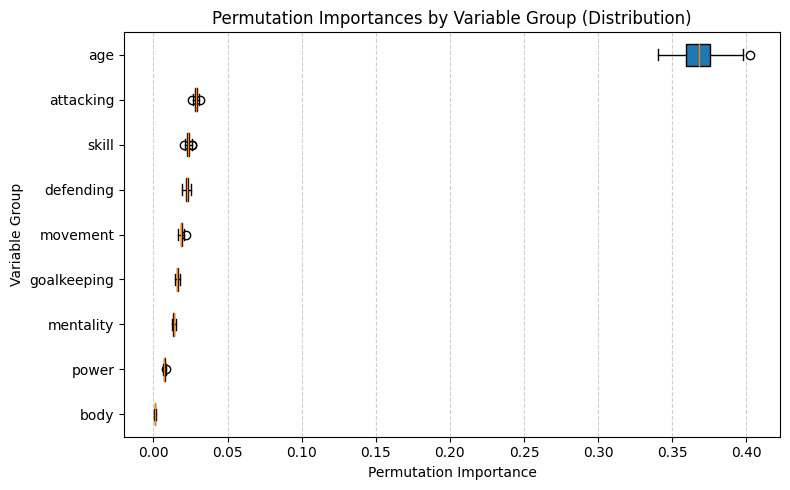

,mean_importance
age,0.368235
attacking,0.028638
skill,0.023517
defending,0.022614
movement,0.018898
goalkeeping,0.016142
mentality,0.013743
power,0.007480
body,0.000963


In [45]:
perm_imp = permutation_importance(model, X_test, ylog_test, n_repeats=100, random_state=0)

group_perm_importance = {}
group_perm_all = {}

for group, features in variable_groups.items():
    valid_feats = [f for f in features if f in X_test.columns]
    if not valid_feats:
        continue
    
    group_indices = [X_test.columns.get_loc(f) for f in valid_feats]

    group_perm_importance[group] = perm_imp.importances_mean[group_indices].mean()

    group_perm_all[group] = perm_imp.importances[group_indices, :].mean(axis=0)

group_perm_df = pd.DataFrame.from_dict(group_perm_importance, orient='index', columns=['mean_importance'])
group_perm_df = group_perm_df.sort_values('mean_importance', ascending=False)


plt.figure(figsize=(8,5))
plt.barh(group_perm_df.index, group_perm_df['mean_importance'], color='lightseagreen')
plt.xlabel('Mean Permutation Importance (R² decrease)')
plt.ylabel('Variable Group')
plt.title('Permutation Feature Importance by Group (Mean)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

group_order = group_perm_df.index.tolist()[::-1]

fig, ax = plt.subplots(figsize=(8,5))
ax.boxplot([group_perm_all[g] for g in group_order], vert=False, labels=group_order, patch_artist=True)
ax.set_title("Permutation Importances by Variable Group (Distribution)")
ax.set_xlabel("Permutation Importance")
ax.set_ylabel("Variable Group")
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

display(group_perm_df)


> For estimating the importance of each group of features we can use the permutation importance technique. We first get the permutation importance of each featur `n_repeats` times. We then group the features on the provided variables and compute the mean importance over the features o each group. We also do this averaged over all the `n_repeats` for the barplot. This way we get a barplot with the averages per group and a more informative boxplot with the distrinution of importances per group.

---
####  Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

> For this exercise we need to use a local interpretability method, since we need something that allows us to explain the individual prediction for a sample. We wil use SHAP since is more stable than LIME and its implementation is more optimized.

In [58]:
# Find Messi in the data
messi_sample = X.loc[df['short_name'] == 'L. Messi']
# Double-check it exists
display(messi_sample)

,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,32,170,72,88,95,70,92,88,97,93,...,75,96,33,37,26,6,11,15,14,8


In [51]:
# Take a random background sample of n players to estimate expected value
n = 200
X_background = shap.utils.sample(X_test, n, random_state=0)
# Create a TreeExplainer for the XGBoost model
explainer = shap.TreeExplainer(model, X_background)


In [52]:
shap_values_messi = explainer.shap_values(messi_sample)
shap_exp_messi = explainer(messi_sample)

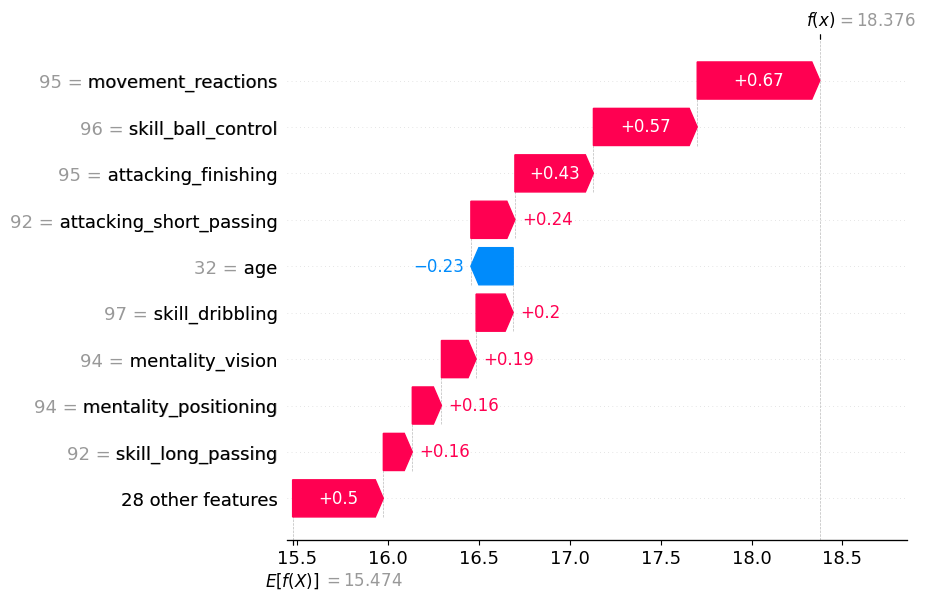

In [53]:
shap.plots.waterfall(shap_exp_messi[0])

> First we computed a waterfall plot for explaining messi's sample. The horizontal axis represents the predicte value (remember is in log scale), the color represent whether the feature increases or decresas the prediction, the length of the bar represent in what magnitude it affect the outcome, and the sample value for each feature is on the left. The expected value for a player from our background samples is 15.474, and the prediction for Messi is 18.376. Whith all this in mind, we can clearly see that the feature with the highest impact is `movement_reactions`, followerd by `skill_control`. In general, all the features in Messi's sample contribute to his value going up, besides `age` (this is because the higher the age the lower the value of the player, which makes sense as their performance tends to drop, although is not too significant in this case).

---
#### Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

In [102]:
# Find Cris in the data
cris_sample = X.loc[df['short_name'] == 'Cristiano Ronaldo']
# Double-check it exists
display(cris_sample)

,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
1,34,187,83,84,94,89,83,87,89,81,...,85,95,28,32,24,7,11,15,14,11


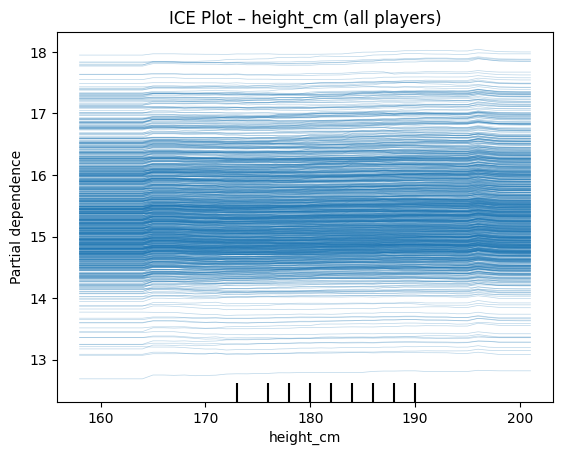

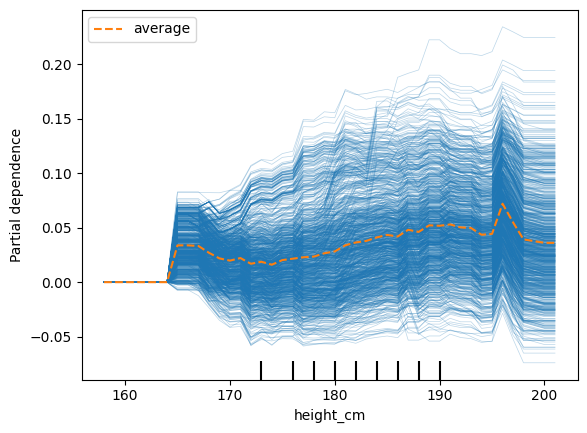

In [ ]:
features = ["height_cm"]
PartialDependenceDisplay.from_estimator(model, X_test, features, kind="individual")
plt.title("ICE Plot – height_cm (all players)")
plt.show()

PartialDependenceDisplay.from_estimator(model, X_test, features, kind="both", centered=True)
plt.show()

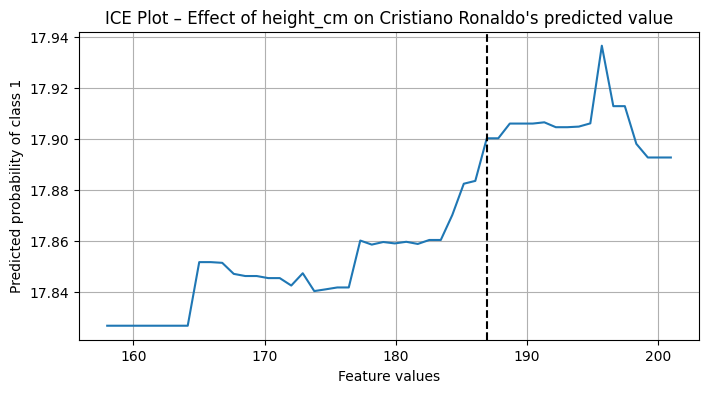

In [77]:
# Choose the instance and feature for which you want to plot the ICE plot
feature = "height_cm"

# Create feature grid
feature_values = np.linspace(X_test[feature].min(), X_test[feature].max(), num=50)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Duplicate the instance to modify feature values
instance_modified = cris_sample.copy()

# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for the instance:
    instance_modified[feature] = value

    # Predict using the modified instance:
    prediction = model.predict(instance_modified)

    # Store the prediction for the current feature value:
    average_predictions[i] = prediction.item()

# Plot the ICE plot
plt.figure(figsize=(8,4))
plt.plot(feature_values, average_predictions)
plt.xlabel(f'Feature values')
plt.ylabel('Predicted probability of class 1')
plt.axvline(cris_sample[feature].values[0], color="k", linestyle="--", label="CR7 actual height")
plt.title("ICE Plot – Effect of height_cm on Cristiano Ronaldo's predicted value")
plt.grid(True)
plt.show()

> For explaining the effect of a feature in a given smaple we use the local explanation model ICE. We first show the ICE plot for the desired feature `height_cm` for all the samples in the test set. Then we do it for Cris's individual sample. In general, the plots show that the lower the height the lower the value, which is realted to real life as taller players tend to perform better. In Cris's case, this rule still applies, as if we increased his height his value is expected to rise (up to a certain height of course, which probably since higher values are too unrealistic the ICE plot is not giving any relevant information. This also applies for low, unrealistic values). In any case, small variantions in Cris's height would not have practically any impact on his valuation, even large fluctuation wouldn't, this most likely given to its valuation not having a large dependance on his height but in other attributes.

---
#### Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

##### ALE plot for average effect of "age"


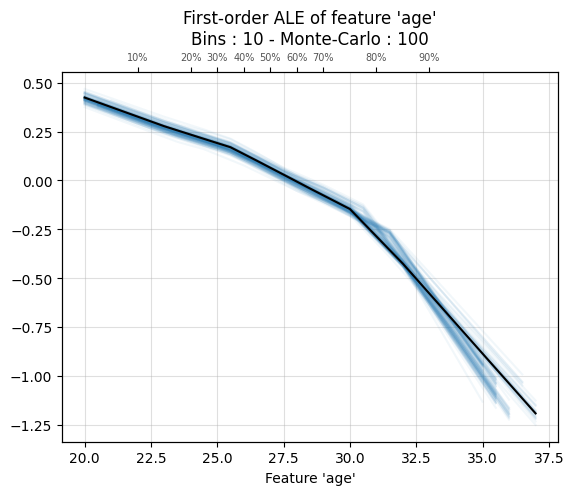

In [95]:
def ale_plot_safe(*args, **kwargs):
    out = ale_plot(*args, **kwargs)
    if isinstance(out, tuple):
        fig, ax = out
    else:
        ax = out
        fig = ax.get_figure()
    return fig, ax

fig, ax = ale_plot_safe(
    model,
    X_test,
    "age",
    bins=10,
    monte_carlo=True,
    monte_carlo_rep=100,
    monte_carlo_ratio=0.5
)
ax.set_title("ALE Plot – Effect of Age")
plt.show()

##### ICE plot for difference along samples in the dataset

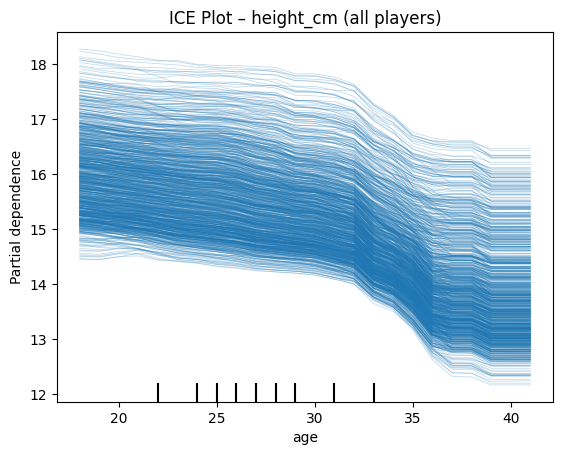

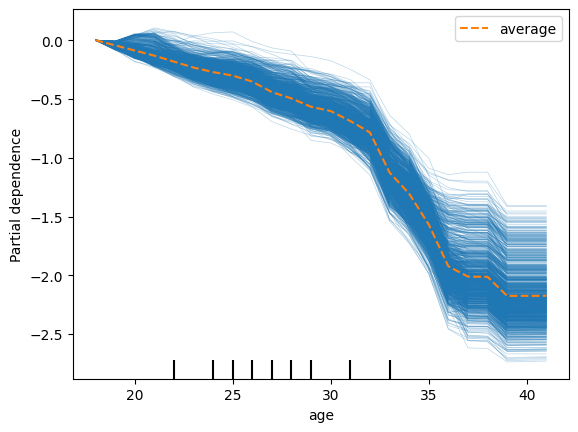

In [80]:
features = ["age"]
PartialDependenceDisplay.from_estimator(model, X_test, features, kind="individual")
plt.title("ICE Plot – height_cm (all players)")
plt.show()

PartialDependenceDisplay.from_estimator(model, X_test, features, kind="both", centered=True)
plt.show()

##### ALE plots for effect of "age" for goalkeepers and strikers

In [91]:
X_test_2 = X_test.copy()

goalkeeping_features = [
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
    'goalkeeping_positioning', 'goalkeeping_reflexes'
]

attacking_features = [
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
    'attacking_short_passing', 'attacking_volleys'
]

# Compute average scores for each group of skills
X_test_2['goalkeeping_mean'] = X_test_2[goalkeeping_features].mean(axis=1)
X_test_2['attacking_mean'] = X_test_2[attacking_features].mean(axis=1)

# Define thresholds to detect player types
goalkeeping_threshold = 50
attacking_threshold = 50

goalkeepers = X_test_2[X_test_2['goalkeeping_mean'] > goalkeeping_threshold].copy().drop(["goalkeeping_mean", "attacking_mean"], axis=1)
strikers = X_test_2[X_test_2['attacking_mean'] > attacking_threshold].copy().drop(["goalkeeping_mean", "attacking_mean"], axis=1)

print(f"Detected {len(goalkeepers)} goalkeepers and {len(strikers)} strikers in X_test.")

Detected 111 goalkeepers and 1034 strikers in X_test.


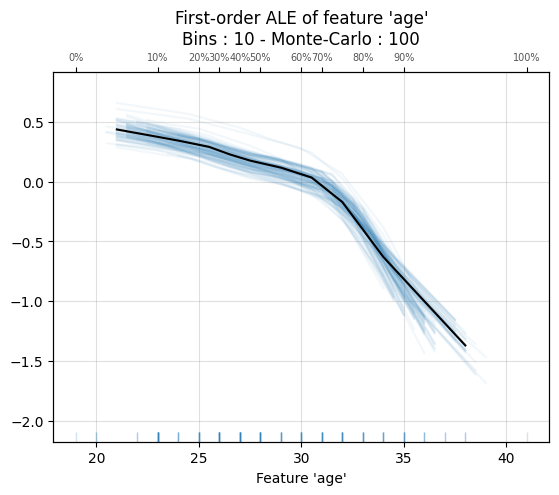

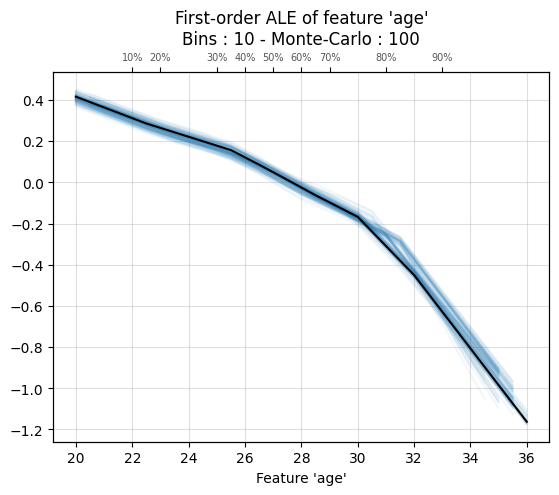

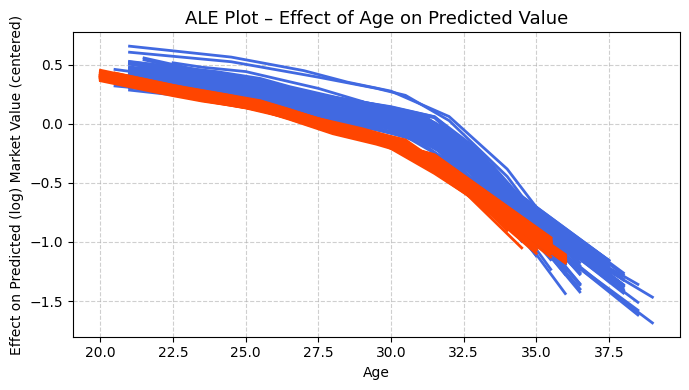

Red strikers, Blue goalkeepers


In [100]:
import matplotlib.pyplot as plt

# --- Compute ALE curves separately (but don’t show them) ---
fig_gk, ax_gk = ale_plot_safe(
    model,
    goalkeepers,
    "age",
    bins=10,
    monte_carlo=True,
    monte_carlo_rep=100,
    monte_carlo_ratio=0.5
)
plt.close(fig_gk)

fig_st, ax_st = ale_plot_safe(
    model,
    strikers,
    "age",
    bins=10,
    monte_carlo=True,
    monte_carlo_rep=100,
    monte_carlo_ratio=0.5
)
plt.close(fig_st)

# --- Create single combined plot ---
fig, ax = plt.subplots(figsize=(7, 4))

# Extract data from both ALE plots and plot them together
if ax_gk and ax_st:
    for line in ax_gk.lines:
        ax.plot(line.get_xdata(), line.get_ydata(),
                color="royalblue", label="Goalkeepers", linewidth=2)
    for line in ax_st.lines:
        ax.plot(line.get_xdata(), line.get_ydata(),
                color="orangered", label="Strikers", linewidth=2)

# --- Style the plot ---
ax.set_title("ALE Plot – Effect of Age on Predicted Value", fontsize=13)
ax.set_xlabel("Age")
ax.set_ylabel("Effect on Predicted (log) Market Value (centered)")
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
print("Red strikers, Blue goalkeepers")


> For this exercise we use both ALE (since we need global explanations) and ICE plots.

> First, with the ALE plot for `age`, we see the average effect of the variable on the predictions. We can see on the graph that the hiher the age, the lower the value, a shortage that gets increasingly worse the higher the age.

> With the ICE plot we can see that indeed all the sample follow this trend, and there is not much difference in between them (although ion higher age bins the variance of the effect is greater along the samples).

> Finally, sepparating the samples using some of the variables and a thershold value for estimating the position, we can compute two sepparate ALE plots, one for goalkeepers and another for strikers. By plotting them together we can clearly appreciate that both follow a similar trend, however strikers fall in value sooner than goalkeepers with the age, and goalkeepers undergo a sharper fall in value from around 31 years of age. With this plot we can also clearly see that goalkeepers have a longer age expentancy of profesional viability.

---
#### Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [108]:
# Find Hazard in the data
hazard_sample = X.loc[df['short_name'] == 'E. Hazard']
# Double-check it exists
display(cris_sample)

,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
1,34,187,83,84,94,89,83,87,89,81,...,85,95,28,32,24,7,11,15,14,11


array([[ 28, 175,  74,  81,  84,  61,  89,  83,  95,  83,  79,  83,  94,
         94,  88,  95,  90,  94,  82,  56,  84,  63,  80,  54,  41,  87,
         89,  88,  91,  34,  27,  22,  11,  12,   6,   8,   8]],
      dtype=int64)

In [111]:
# Define kernel_width
kernel_width = 3

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_test.values,
    feature_names=list(X_test.columns),
    kernel_width=kernel_width,
    mode="regression",
    discretize_continuous=True,
    sample_around_instance=True
)

# Choose a sample for explanation

# Explain the prediction using LIME
exp = explainer.explain_instance(hazard_sample.values[0], model.predict, num_features=12)

# Show the explanation
exp.show_in_notebook(show_table=True)

> This time we use LIME as a different local explainability model than SHAP. The plot shows the results of LIME for the sample of Hazard. His predicted value is of 18.33 (log) and the values of its features are on the right table. The middle plot shows whether a feature contributed positively or negatively to the predicted value of the player. Clearly most of the features contributed positively for his value, with `movement_reactions` contributing the most, and only one feature, `power_strength`, contributed in a negative but very slightly, almost neglegible, way.